In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys


if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib import plotting
from lib.tile_coding import IHT, tiles

matplotlib.style.use('ggplot')

In [2]:
env = gym.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class Featurizer():
    
    def __init__(self, num_tilings=8, max_size=4096):
        self.max_size = max_size
        self.num_tilings = num_tilings
        self.iht = IHT(max_size)
        
        self.position_scale = self.num_tilings / \
            (env.observation_space.high[0] - env.observation_space.low[0])
        self.velocity_scale = self.num_tilings / \
            (env.observation_space.high[1] - env.observation_space.low[1])
        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a state.
        """
        featurized = tiles(self.iht, self.num_tilings, [self.position_scale * state[0], self.velocity_scale * state[1]], [action])
        return featurized

In [4]:
class Featurizer():
    
    def __init__(self, env, n_states):
        self.env_low = env.observation_space.low
        self.env_high = env.observation_space.high
        self.n_states = n_states
        self.env_dx = (self.env_high - self.env_low) / self.n_states
        
    def featurize_state_action(self, state):
        """
        Returns the featurized representation for a state.
        """
        a = int((state[0] - self.env_low[0])/self.env_dx[0])
        b = int((state[1] - self.env_low[1])/self.env_dx[1])
        return a, b

In [5]:
class Q():
    
    def __init__(self, featurizer):
        self.q_table = defaultdict(lambda: 0)
        self.featurizer = featurizer
    
    def __getitem__(self, s):
        features = [featurizer.featurize_state_action(s, i) 
                    for i in range(env.action_space.n)]
        return [self.q_table[tuple(f)] for f in features]
    
    def __setitem__(self, state_action, value):
        state, action = state_action
        features = featurizer.featurize_state_action(state, action)
        self.q_table[tuple(features)] = value

In [6]:
class Q():
    
    def __init__(self, featurizer):
        self.q_table = np.zeros((featurizer.n_states, featurizer.n_states, 3))
        self.featurizer = featurizer
    
    def __getitem__(self, s):
        pos, vel = featurizer.featurize_state_action(s)
        return self.q_table[pos][vel]
    
    def __setitem__(self, state_action, value):
        state, action = state_action
        pos, vel = featurizer.featurize_state_action(state)
        self.q_table[pos][vel][action] = value

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [8]:
def q_learning(Q, env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        
        next_action = None
        for t in itertools.count():
            
            # Take a step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
                
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Q learning update
            #best_next_action = np.argmax(Q[next_state])    
            #td_target = reward + discount_factor * Q[next_state][best_next_action]
            #td_delta = td_target - Q[state][action]
            #Q[(state, action)] = Q[state][action] + alpha * td_delta
            
            # TD update (sarsa)
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[(state, action)] = Q[state][action] + alpha * td_delta
            
            #print("\rStep {} @ Episode {}/{} ({})".format(
             #   t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
        
        if i_episode % 100 == 0:
            print('Iteration #%d -- Total reward = %d.' %(i_episode+1, last_reward))
    
    return Q, stats

In [9]:
#featurizer = Featurizer()
#Qvalue = Q(featurizer)
featurizer = Featurizer(env, 40)
Qvalue = Q(featurizer)

In [10]:
Qopt, stats = q_learning(Qvalue, env, 10000, epsilon=0.02)

Iteration #1 -- Total reward = 0.
Iteration #101 -- Total reward = -200.
Iteration #201 -- Total reward = -200.
Iteration #301 -- Total reward = -200.
Iteration #401 -- Total reward = -200.
Iteration #501 -- Total reward = -200.
Iteration #601 -- Total reward = -200.
Iteration #701 -- Total reward = -196.
Iteration #801 -- Total reward = -200.
Iteration #901 -- Total reward = -174.
Iteration #1001 -- Total reward = -200.
Iteration #1101 -- Total reward = -200.
Iteration #1201 -- Total reward = -200.
Iteration #1301 -- Total reward = -200.
Iteration #1401 -- Total reward = -200.
Iteration #1501 -- Total reward = -200.
Iteration #1601 -- Total reward = -200.
Iteration #1701 -- Total reward = -200.
Iteration #1801 -- Total reward = -160.
Iteration #1901 -- Total reward = -200.
Iteration #2001 -- Total reward = -165.
Iteration #2101 -- Total reward = -157.
Iteration #2201 -- Total reward = -200.
Iteration #2301 -- Total reward = -200.
Iteration #2401 -- Total reward = -189.
Iteration #2501

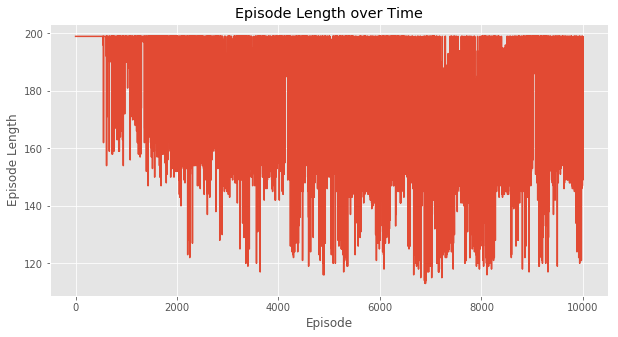

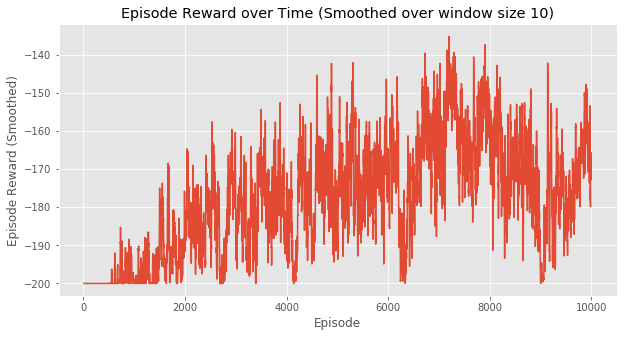

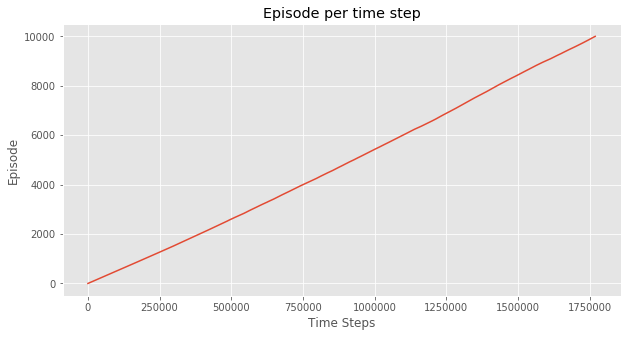

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_episode_stats(stats)

In [18]:
import time
env = gym.make("MountainCar-v0")
epsilon = 0
# The policy we're following
policy = make_epsilon_greedy_policy(
        Qopt, epsilon, env.action_space.n)
#for i_episide in range(20):
state = env.reset()
for t in itertools.count():
    #env.render()
    time.sleep(0.01)
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [19]:
np.sum(Qopt.q_table != 0)

3454

In [20]:
np.size(Qopt.q_table)

4800